In [1]:
from pathlib import Path
import json
import pandas as pd
import numpy as np
import re
import ast
import pandas as pd

#### Load in Training Data.

In [14]:
# load in combined training data.
import pandas as pd

router_test_data = pd.read_csv('/dccstor/gma2/jhjenny9/search-and-learn/data/all_softlabel_train.csv')
router_test_data = pd.read_csv('/dccstor/gma2/jhjenny9/search-and-learn/data/bert-features/df_train.csv')
# change the column name from "SL" to "sl".
router_test_data.head(), router_test_data.columns, router_test_data['question'].unique().shape
# must route on math500 for now...? unless i find a dataset for numina5000 that contains token counts + latencies.

(                                            question   N   sl  \
 0  \nA $10 \times 10$ table is filled with number...   2  0.0   
 1  \nA $10 \times 10$ table is filled with number...   4  0.0   
 2  \nA $10 \times 10$ table is filled with number...   8  1.0   
 3  \nA $10 \times 10$ table is filled with number...  16  0.0   
 4  \nA random walk of a point starts from the ori...   2  0.0   
 
    question_length  sb_idx  method_beam_search  method_majority  method_naive  \
 0              451     101                True            False         False   
 1              451     101                True            False         False   
 2              451     101                True            False         False   
 3              451     101                True            False         False   
 4              483     381                True            False         False   
 
    method_weighted       method  
 0            False  beam_search  
 1            False  beam_search  
 2 

In [4]:
# load in combined training data.
import pandas as pd

combined_training_data = pd.read_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/sl/combined_training_data.csv")
# change the column name from "SL" to "sl".
combined_training_data.rename(columns={"SL": "sl"}, inplace=True)
combined_training_data.head()

,question,N,method,sl
0,Through the midpoint \(M\) of side \(BC\) of p...,2,beam_search,0.000000
1,Given $x=\log_{5}6\cdot\log_{6}7\cdot\log_{7}8...,2,beam_search,0.000000
2,"Let $a,$ $b,$ $c$ be positive real numbers suc...",2,beam_search,0.433333
3,Given that the graph of the quadratic function...,2,beam_search,0.600000
4,"Three circles $\mathcal{K}_1$ , $\mathcal{K}...",2,beam_search,1.000000


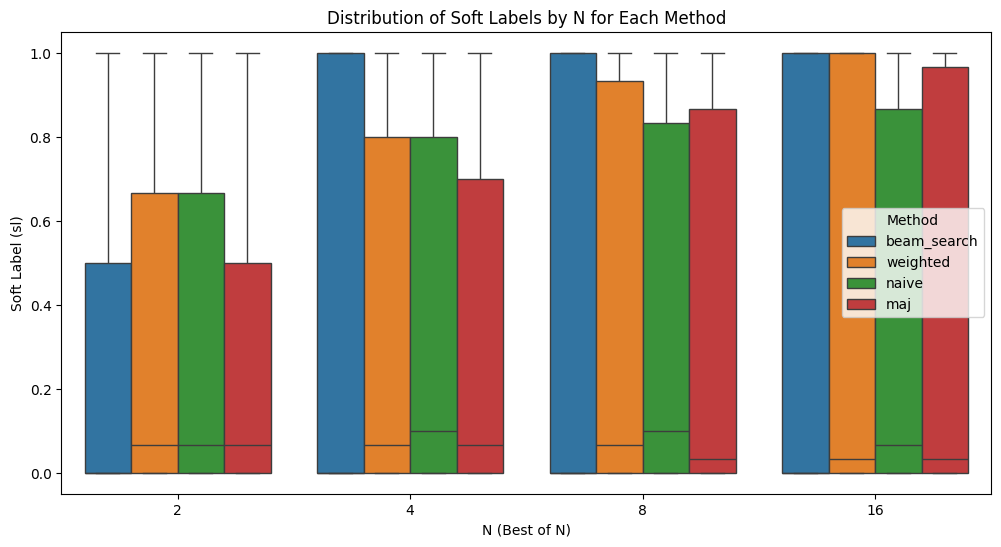

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.boxplot(x="N", y="sl", hue="method", data=combined_training_data)
plt.title("Distribution of Soft Labels by N for Each Method")
plt.xlabel("N (Best of N)")
plt.ylabel("Soft Label (sl)")
plt.legend(title="Method")
plt.show()

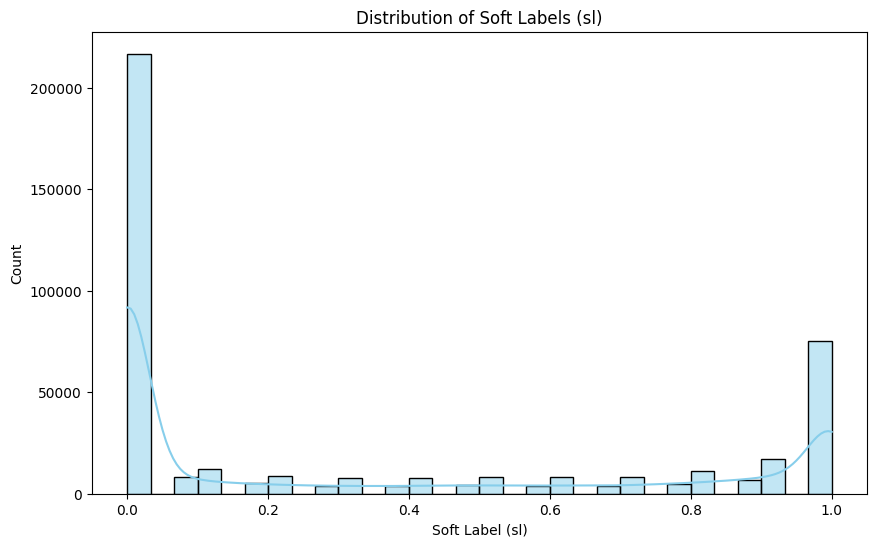

In [6]:
plt.figure(figsize=(10, 6))
sns.histplot(combined_training_data["sl"], bins=30, kde=True, color='skyblue', edgecolor='black')
plt.title("Distribution of Soft Labels (sl)")
plt.xlabel("Soft Label (sl)")
plt.ylabel("Count")
plt.show()



In [7]:
combined_training_data.shape, combined_training_data["question"].unique().shape

((426617, 4), (29862,))

Drop questions that are overly difficult (all zeros in all N's)

In [8]:
import sys
import os
sys.path.append('/dccstor/gma2/jhjenny9/search-and-learn/scripts')

# Now you can import
import data_processing.filter_questions

# Drop 80% of questions that have all zeros across all N values
filtered_zeros_df = data_processing.filter_questions.drop_extreme_questions(
    df=combined_training_data,
    target_value=0,        # Target zeros
    min_target_N=3,          # Must have zeros for at least 3 N values
    frac=0.8,                # Drop 80% of eligible questions
    random_state=42          # For reproducible results
)

filtered_df = data_processing.filter_questions.drop_extreme_questions(
    df=filtered_zeros_df,
    target_value=1,        # Target ones
    min_target_N=4,          # Must have ones for at least 5 N values
    frac=0.8,                # Drop 80% of eligible questions
    random_state=42          # For reproducible results
)

In [9]:
filtered_df["question"].unique().shape

(17053,)

We are now left with 15,808 unique questions.
You might think to add back the question so that the model can learn question embeddings better.

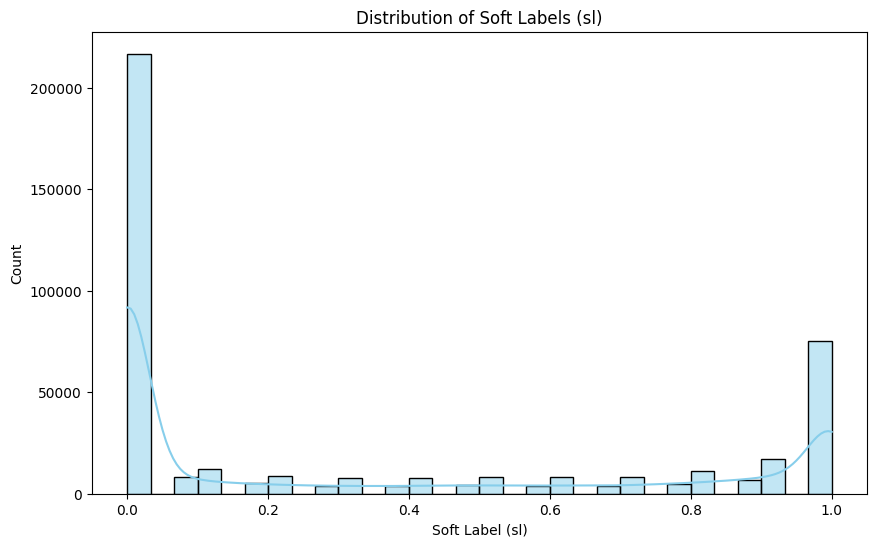

In [94]:
plt.figure(figsize=(10, 6))
sns.histplot(filtered_df["sl"], bins=30, kde=True, color='skyblue', edgecolor='black')
plt.title("Distribution of Soft Labels (sl)")
plt.xlabel("Soft Label (sl)")
plt.ylabel("Count")
plt.show()

In [10]:
filtered_df.head()

,question,N,method,sl
0,"Let $a,$ $b,$ $c$ be positive real numbers suc...",2,beam_search,0.433333
1,Given that the graph of the quadratic function...,2,beam_search,0.600000
2,How many three-digit numbers are multiples of ...,2,beam_search,0.000000
3,Find the value of the algebraic expression $2\...,2,beam_search,0.000000
4,Jack and Rose want to start a dog-walking busi...,2,beam_search,0.500000


In [96]:
### change completion_tokens froms str --> a list of ints.
# filtered_df["completion_tokens"] = filtered_df["completion_tokens"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Compute length of question (aka, length of the string)
filtered_df["question_length"] = filtered_df["question"].str.len()

# Compute token count from completion_tokens
# filtered_df["token_count"] = filtered_df["completion_tokens"].apply(sum)
# turn completion tokens into a list of ints.
# filtered_df["completion_tokens"] = filtered_df["completion_tokens"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
# Obtain Token Count for Best of N.
# filtered_df["token_count"] = filtered_df.apply(lambda row: sum(row["completion_tokens"][:row["N"]]), axis=1)
filtered_df = pd.get_dummies(filtered_df, columns=["method"])
filtered_df.shape
# Transform method columns into a single 'method' column.

def decode_method(row):
    if row["method_maj"]:
        return "majority"
    elif row["method_naive"]:
        return "naive"
    elif row["method_weighted"]:
        return "weighted"
    elif row["method_beam_search"]:
        return "beam_search"
    else:
        return "unknown"

# Apply the function row-wise
filtered_df["method"] = filtered_df.apply(decode_method, axis=1)

Add sb_idx (question id) column.

In [97]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), '..'))
import data_processing.create_question_id

# Fit on filtered_df and save
q_to_id = data_processing.create_question_id.build_q_to_id(filtered_df, question_col="question", start=0)
data_processing.create_question_id.save_mapping(q_to_id, "q_to_id.json")

# Load and apply to filtered_df
q_to_id = data_processing.create_question_id.load_mapping("q_to_id.json")
filtered_df = data_processing.create_question_id.apply_q_to_id(filtered_df, q_to_id, question_col="question")


In [98]:
filtered_df.head(), filtered_df.shape

(                                            question  N        sl  \
 0  Through the midpoint \(M\) of side \(BC\) of p...  2  0.000000   
 1  Given $x=\log_{5}6\cdot\log_{6}7\cdot\log_{7}8...  2  0.000000   
 2  Let $a,$ $b,$ $c$ be positive real numbers suc...  2  0.433333   
 3  Given that the graph of the quadratic function...  2  0.600000   
 4  Three circles  $\mathcal{K}_1$ ,  $\mathcal{K}...  2  1.000000   
 
    question_length  method_beam_search  method_maj  method_naive  \
 0              208                True       False         False   
 1              138                True       False         False   
 2              106                True       False         False   
 3              356                True       False         False   
 4              582                True       False         False   
 
    method_weighted       method  sb_idx  
 0            False  beam_search   27651  
 1            False  beam_search    9799  
 2            False  beam_search 

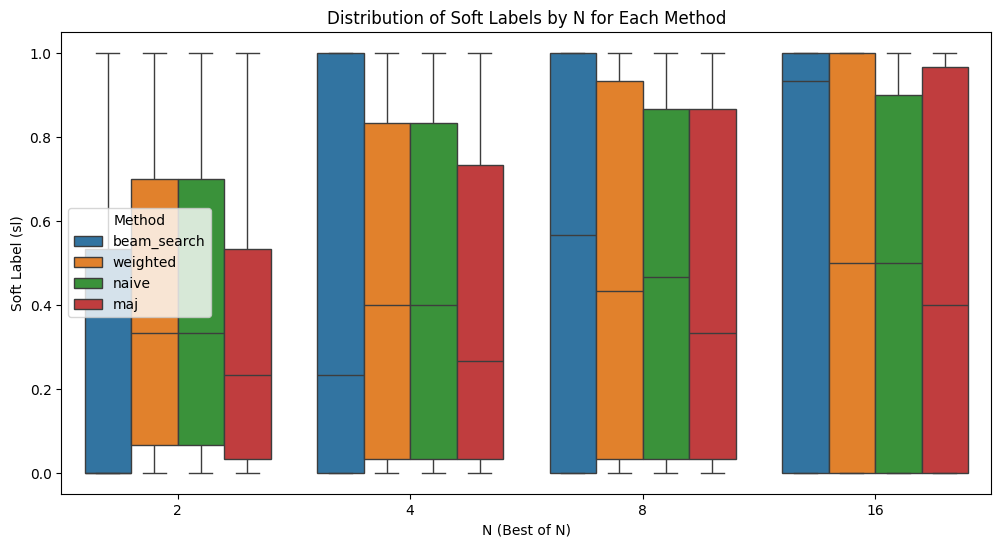

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.boxplot(x="N", y="sl", hue="method", data=filtered_df)
plt.title("Distribution of Soft Labels by N for Each Method")
plt.xlabel("N (Best of N)")
plt.ylabel("Soft Label (sl)")
plt.legend(title="Method")
plt.show()

Beam_search is more varied depending on N (it goes from much lower to much higher).

In [100]:
# create train/val/test split based on 'sb_idx' (query identifier)
from sklearn.model_selection import train_test_split

unique_sb_idx = filtered_df['sb_idx'].unique()

# Split into train and test only
sb_idx_train, sb_idx_test = train_test_split(
    unique_sb_idx,
    test_size=0.15,
    random_state=42
)

# Divide queries (represented by sb_idx) into train and test
df_train = filtered_df[filtered_df['sb_idx'].isin(sb_idx_train)].reset_index(drop=True)
df_test = filtered_df[filtered_df['sb_idx'].isin(sb_idx_test)].reset_index(drop=True)

In [101]:
df_train.shape, df_test.shape

((362558, 10), (64059, 10))

START HERE: if you have df_train.

In [3]:
# df_train.to_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/bert-features/df_train_29000.csv", index=False)
# df_test.to_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/bert-features/df_test_29000.csv", index=False)

# read in df_train, df_val, df_test.
df_train = pd.read_csv("/dccstor/gma2/jhjenny9/search-and-learn/feature-data/numina_5000_no_extremely_hards/df_train_numina_5000_no_extremely_hards.csv")
df_test = pd.read_csv("/dccstor/gma2/jhjenny9/search-and-learn/feature-data/numina_5000_no_extremely_hards/df_train_numina_5000_no_extremely_hards.csv")

df_train.shape, df_test.shape

((61256, 10), (61256, 10))

In [4]:
df_train.head()

,question,N,sl,question_length,sb_idx,method_beam_search,method_majority,method_naive,method_weighted,method
0,\nA $10 \times 10$ table is filled with number...,2,0.0,451,101,True,False,False,False,beam_search
1,\nA $10 \times 10$ table is filled with number...,4,0.0,451,101,True,False,False,False,beam_search
2,\nA $10 \times 10$ table is filled with number...,8,1.0,451,101,True,False,False,False,beam_search
3,\nA $10 \times 10$ table is filled with number...,16,0.0,451,101,True,False,False,False,beam_search
4,\nA natural number \( N \) is represented as \...,2,0.0,392,332,True,False,False,False,beam_search


#### EDA: training and testing dataframes by method, N.

/tmp/ipykernel_129546/2205889479.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_129546/2205889479.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


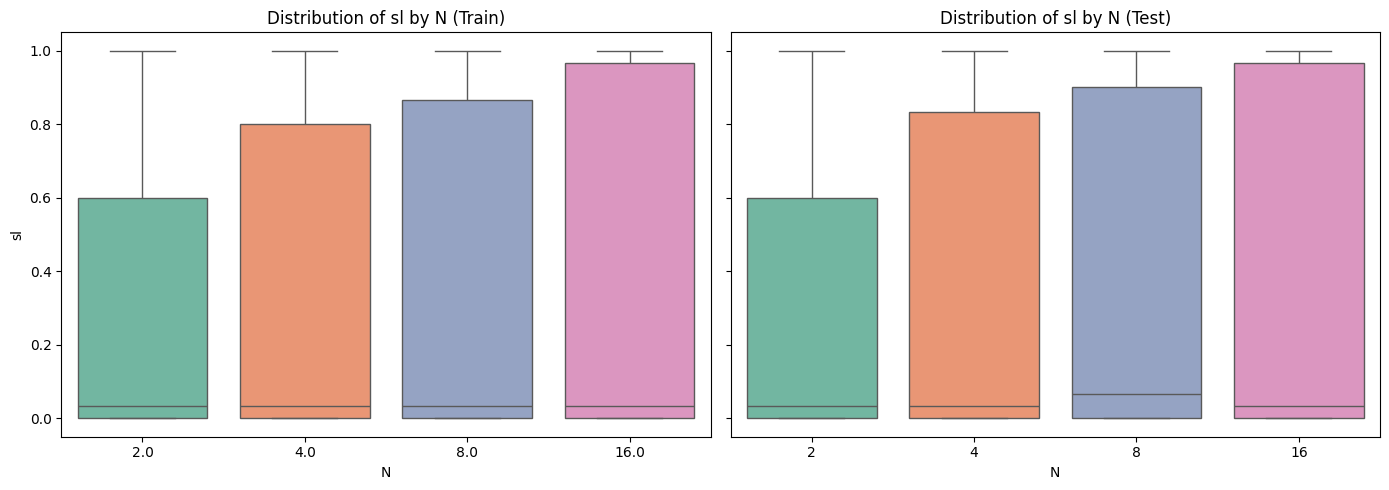

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

for i, (df, name) in enumerate(zip([df_train, df_test], ["Train", "Test"])):
    sns.boxplot(
        x="N", y="sl", data=df, ax=axes[i], showfliers=False, palette="Set2"
    )
    axes[i].set_title(f"Distribution of sl by N ({name})")
    axes[i].set_xlabel("N")
    axes[i].set_ylabel("sl" if i == 0 else "")

plt.tight_layout()
plt.show()


/tmp/ipykernel_129546/1004913509.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_129546/1004913509.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


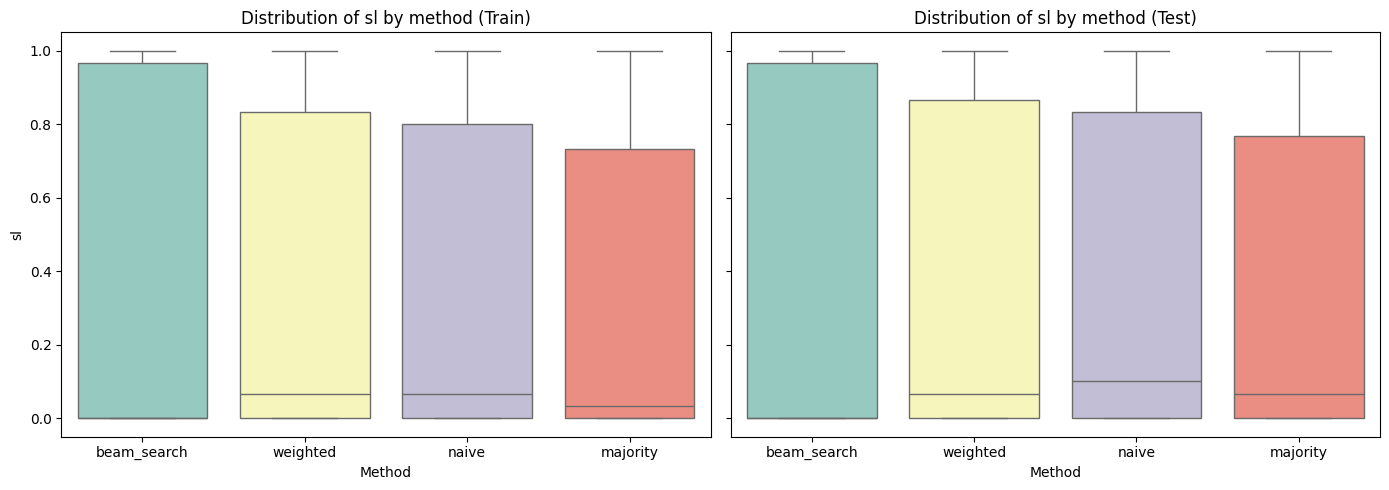

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

for i, (df, name) in enumerate(zip([df_train, df_test], ["Train", "Test"])):
    sns.boxplot(
        x="method", y="sl", data=df, ax=axes[i], showfliers=False, palette="Set3"
    )
    axes[i].set_title(f"Distribution of sl by method ({name})")
    axes[i].set_xlabel("Method")
    axes[i].set_ylabel("sl" if i == 0 else "")

plt.tight_layout()
plt.show()


### Extract Features for Difficulty Probe.

the features are created using Python scripts in the folder labeled "features" in the "scripts" subdirectory.

In [146]:
# df_train.to_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/bert-features/df_train_29000.csv", index=False)
# df_test.to_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/bert-features/df_test_29000.csv", index=False)

# read in df_train, df_val, df_test.
df_train = pd.read_csv("/dccstor/gma2/jhjenny9/search-and-learn/feature-data/bert-features/16000/df_train_16000.csv")
df_test = pd.read_csv("/dccstor/gma2/jhjenny9/search-and-learn/feature-data/bert-features/16000/df_test_16000.csv")

df_train.shape, df_test.shape

((191341, 10), (33842, 10))

In [147]:
df_train.head()

,question,N,sl,question_length,method_beam_search,method_maj,method_naive,method_weighted,method,sb_idx
0,Given that the graph of the quadratic function...,2,0.600000,356,True,False,False,False,beam_search,6373
1,How many three-digit numbers are multiples of ...,2,0.000000,63,True,False,False,False,beam_search,7641
2,The line with equation \( y = 2x - 6 \) is ref...,2,0.566667,148,True,False,False,False,beam_search,13446
3,"Given fixed points \( A(3,0) \), \( B(0,4) \),...",2,0.000000,201,True,False,False,False,beam_search,5742
4,"In the lunch room, there were 14 chairs in the...",2,0.500000,291,True,False,False,False,beam_search,9545


In [ ]:
X_train = np.load("/dccstor/gma2/jhjenny9/search-and-learn/feature-data/bert-features/16000/train_features_BERT_pca_32.npy")
y_train = df_train["sl"].values.astype(float)

In [ ]:
X_val = np.load("/dccstor/gma2/jhjenny9/search-and-learn/feature-data/bert-features/16000/val_features_BERT_pca_32.npy")
y_val = df_test["sl"].values.astype(float)


In [150]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((191341, 70), (191341,), (33842, 70), (33842,))

### Load in Training/Testing Data

### Train MLP.

In [103]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

In [104]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)

In [105]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape # old ((37440, 1542), (37440,), (6624, 1542), (6624,))

((191341, 70), (191341,), (33842, 70), (33842,))

### Create Custom MLP

In [106]:
import torch
import torch.nn as nn                       
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

In [ ]:
# ----- 2. Dataset Definition -----
class SoftLabelDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# ----- 3. Dataloaders -----
train_dataset = SoftLabelDataset(X_train, y_train)
val_dataset = SoftLabelDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# ----- 4. MLP Model - following from the LLM Routing Paper. -----
# Add one repetition of the auxiliary features (last 6 dims) as extra input into each layer
class MLP(nn.Module):
    def __init__(self, input_dim,bert_model):
        super(MLP, self).__init__()
        self.input_dim = input_dim
        self.bert_model = bert_model
        self.model = nn.Sequential(
            nn.Linear(input_dim,16),
            nn.BatchNorm1d(16),
            nn.GELU(),
            nn.Linear(16, 4),
            nn.BatchNorm1d(4),
            nn.GELU(),
            nn.Linear(4, 1),
            nn.Sigmoid()
        )

    def forward(self, x,numerical_features):
        # do forward through BERT.
        with torch.no_grad():
            embeddings = self.bert_model(x)
            chosen_embedding = # take the CLS token embedding.
            # concatenate the last 6 dims of x to the first 64 dims of x.
            combined  = torch.cat(chosen_embedding, numerical_features) 
        # do forward pass through MLP.
        final = self.mlp(final)

        return final

model = MLP(input_dim=70)

# ----- 5. Loss and Optimizer -----
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
# ----- 6. Training Loop -----
num_epochs = 2 
batch_size = 128    # Batch size of 128

agg_train_loss = []
agg_val_loss = []
step_train_loss = []
step_val_loss = []
best_val_loss = float('inf')
early_stop_counter = 0
counter = 0 
train_steps,val_steps = [],[]

for epoch in range(num_epochs):
    model.train()
    train_loss = []
    for i, (batch_X, batch_y) in enumerate(train_loader):
        counter += 1
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_steps.append(counter)
        train_loss.append(loss.item())
        step_train_loss.append(loss.item())
        if (i + 1) % 100 == 0:
            model.eval()
            val_loss_step = []
            with torch.no_grad():
                for val_X, val_y in val_loader:
                    val_preds = model(val_X)
                    val_loss_step.append(criterion(val_preds, val_y).item())
            mean_val_loss_step = np.mean(val_loss_step)
            step_val_loss.append(mean_val_loss_step)
            val_steps.append(counter)
            print(f"Epoch {epoch+1}, Step {i+1}, Train Loss: {loss.item():.4f}, Val Loss: {mean_val_loss_step:.4f}")
            model.train()


Epoch 1, Step 100, Train Loss: 0.7324, Val Loss: 0.7173
Epoch 1, Step 200, Train Loss: 0.7297, Val Loss: 0.7090
Epoch 1, Step 300, Train Loss: 0.6849, Val Loss: 0.7022
Epoch 1, Step 400, Train Loss: 0.7052, Val Loss: 0.6975
Epoch 1, Step 500, Train Loss: 0.7280, Val Loss: 0.6923
Epoch 1, Step 600, Train Loss: 0.6879, Val Loss: 0.6879
Epoch 1, Step 700, Train Loss: 0.6813, Val Loss: 0.6851
Epoch 1, Step 800, Train Loss: 0.6449, Val Loss: 0.6812
Epoch 1, Step 900, Train Loss: 0.6616, Val Loss: 0.6775
Epoch 1, Step 1000, Train Loss: 0.6636, Val Loss: 0.6761
Epoch 1, Step 1100, Train Loss: 0.6837, Val Loss: 0.6749
Epoch 1, Step 1200, Train Loss: 0.6411, Val Loss: 0.6708
Epoch 1, Step 1300, Train Loss: 0.6772, Val Loss: 0.6684
Epoch 1, Step 1400, Train Loss: 0.6720, Val Loss: 0.6669
Epoch 1, Step 1500, Train Loss: 0.6732, Val Loss: 0.6641
Epoch 1, Step 1600, Train Loss: 0.6613, Val Loss: 0.6636
Epoch 1, Step 1700, Train Loss: 0.6736, Val Loss: 0.6605
Epoch 1, Step 1800, Train Loss: 0.6627, 

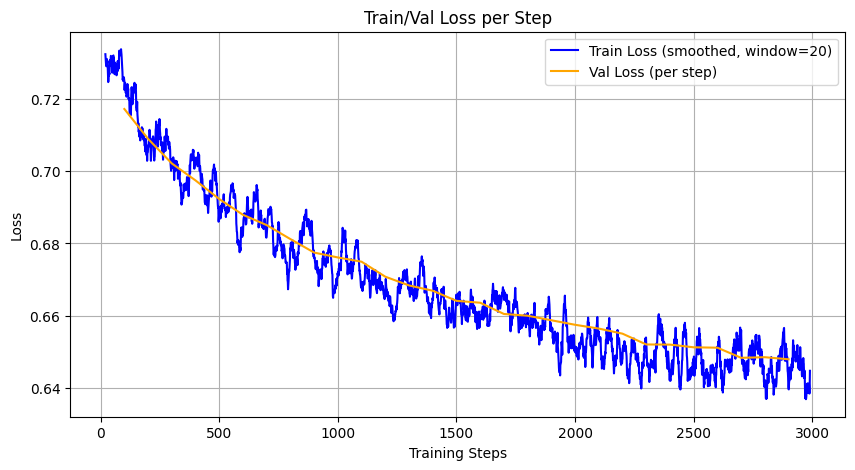

In [122]:
# ----- 7. Plot Training and Validation Loss (per step) -----
import matplotlib.pyplot as plt
import numpy as np

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

plt.figure(figsize=(10, 5))
window = 20  # tweak as needed
smoothed_train_loss = moving_average(step_train_loss, window)
smoothed_train_steps = train_steps[window-1:] if len(train_steps) == len(step_train_loss) else np.arange(len(smoothed_train_loss))
plt.plot(smoothed_train_steps, smoothed_train_loss, label=f'Train Loss (smoothed, window={window})', color='blue')
plt.plot(val_steps, step_val_loss, label='Val Loss (per step)', color='orange')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Train/Val Loss per Step')
plt.legend()
plt.grid(True)
plt.show()

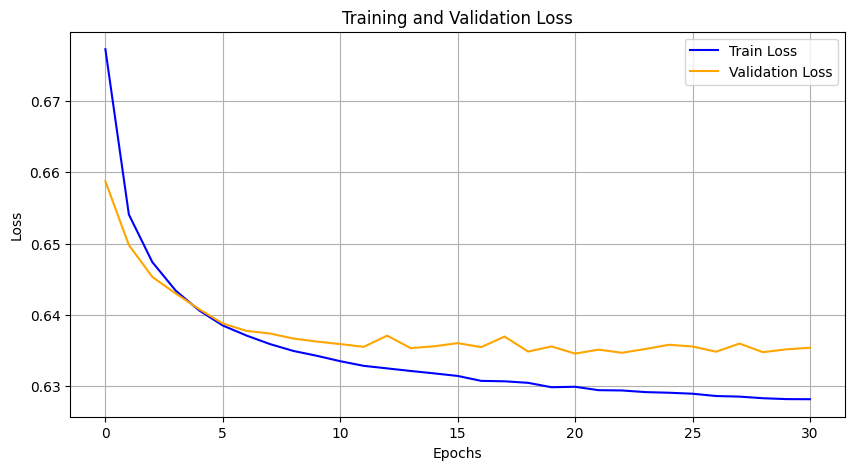

In [28]:
# ----- 7. Plot Training and Validation Loss -----
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(agg_train_loss, label='Train Loss', color='blue')
plt.plot(agg_val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

#### Make Predictions on Test.

In [29]:
X_val.shape

(33842, 38)

In [ ]:
model.eval()
X_test_tensor = torch.tensor(X_val, dtype=torch.float32)

with torch.no_grad():
    softLabel_Preds = model(X_test_tensor)

softLabel_preds_numpy = softLabel_Preds.squeeze().cpu().numpy()
softLabel_preds_numpy

In [31]:
softLabel_preds_numpy = softLabel_Preds.squeeze().cpu().numpy()
softLabel_preds_numpy

array([0.39059216, 0.582333  , 0.22207221, ..., 0.8313635 , 0.8189866 ,
       0.7854523 ], dtype=float32)

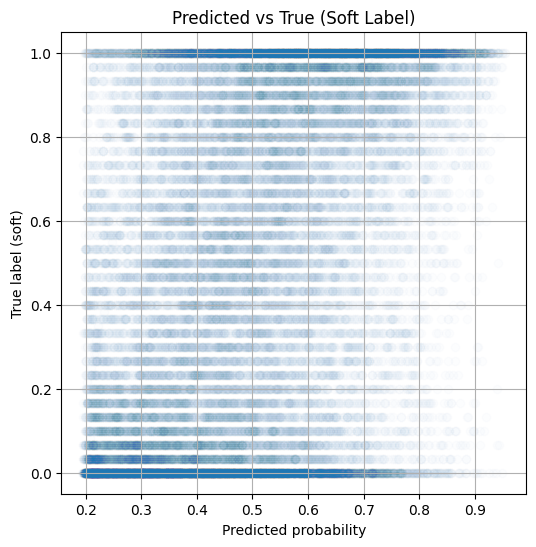

In [ ]:
plt.figure(figsize=(6, 6)) # the probe is being conservative in predicting extreme values.
# look at targets for training.
# after every validation loss, plot a calibration chart... after each epoch...
plt.scatter(softLabel_preds_numpy, y_val, alpha=1e-2)
plt.xlabel("Predicted probability")
plt.ylabel("True label (soft)")
plt.title("Predicted vs True (Soft Label)")
plt.grid(True)
plt.show()

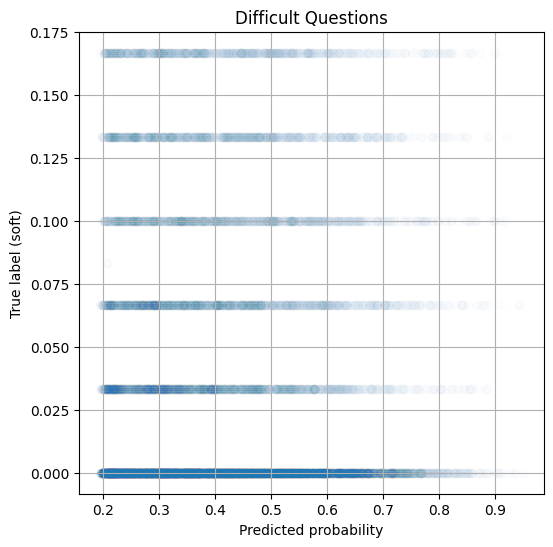

In [195]:
plt.figure(figsize=(6, 6)) # the probe is being conservative in predicting extreme values.
# look at targets for training.
# after every validation loss, plot a calibration chart... after each epoch...
plt.scatter(difficult_test_df["predicted_prob"], difficult_test_df["sl"], alpha=1e-2)
plt.xlabel("Predicted probability")
plt.ylabel("True label (soft)")
plt.title("Difficult Questions")
plt.grid(True)
plt.show()

In [151]:
df_test['predicted_prob'] = softLabel_preds_numpy

AUC: 0.7254


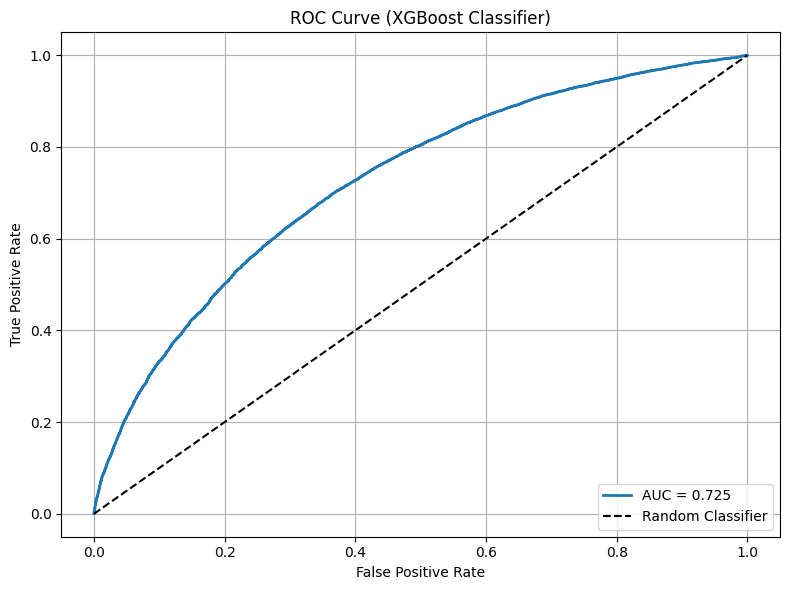

In [152]:
### Train XGBoost Classifier
y_test_binary = y_val > 0.5
from sklearn.metrics import roc_auc_score
# Compute AUC
auc = roc_auc_score(y_test_binary, softLabel_preds_numpy)
print(f"AUC: {auc:.4f}")
# AUC with all features.

from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test_binary, softLabel_preds_numpy)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}", linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (XGBoost Classifier)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()

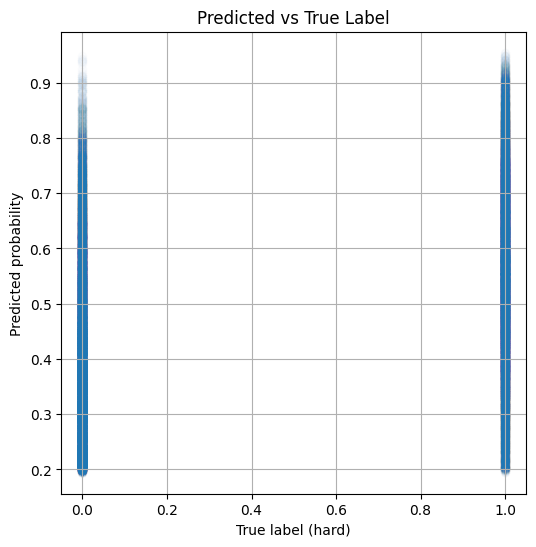

In [153]:
import matplotlib.pyplot as plt
# the XGBoost model does slightly better in outputting predicted probabilities.
plt.figure(figsize=(6, 6))
plt.scatter(y_test_binary, softLabel_preds_numpy, alpha=1e-2)
plt.xlabel("True label (hard)")
plt.ylabel("Predicted probability")
plt.title("Predicted vs True Label")
plt.grid(True)
plt.show()

In [ ]:
# df_train['predicted_prob'] = hardLabel_preds_numpy
# df_test['predicted_prob'] = hardLabel_preds_numpy # PyTorch MLP predictions from hard label.
# df_train['predicted_prob'] = y_proba_train # sklearn MLPClassifier predictions (hard label version)

In [154]:
# there should be 23 different BoN configurations for each query in the test set.
df_test.groupby('sb_idx').size().reset_index(name='count')

,sb_idx,count
0,2,15
1,7,14
2,17,15
3,25,15
4,35,14
...,...,...
2366,15786,14
2367,15795,12
2368,15797,12
2369,15798,15


Add token counts for parallel methods and for beam.

In [155]:
# created using concatenate_completions.py.
bon_token_counts = pd.read_csv('/dccstor/gma2/jhjenny9/search-and-learn/training-res/numinaMath/bon_token_counts_16000.csv')
bon_token_counts = bon_token_counts.rename(columns={"problem": "question"})
bon_token_counts.head()

,question,completion_tokens
0,Through the midpoint \(M\) of side \(BC\) of p...,"[456, 379, 547, 438, 475, 981, 397, 459, 590, ..."
1,Given $x=\log_{5}6\cdot\log_{6}7\cdot\log_{7}8...,"[513, 2048, 524, 614, 507, 545, 531, 575, 717,..."
2,"Let $a,$ $b,$ $c$ be positive real numbers suc...","[1285, 990, 883, 698, 749, 400, 877, 1020, 620..."
3,Given that the graph of the quadratic function...,"[1016, 731, 886, 1084, 828, 682, 822, 863, 837..."
4,"Three circles $\mathcal{K}_1$ , $\mathcal{K}...","[620, 629, 706, 678, 703, 573, 516, 641, 831, ..."


In [156]:
df_test.head()

,question,N,sl,question_length,method_beam_search,method_maj,method_naive,method_weighted,method,sb_idx,predicted_prob
0,"Let $a,$ $b,$ $c$ be positive real numbers suc...",2,0.433333,106,True,False,False,False,beam_search,10432,0.390592
1,Jack and Rose want to start a dog-walking busi...,2,0.500000,229,True,False,False,False,beam_search,9858,0.582333
2,Let $\mathbb{N}$ denote the set of all posit...,2,0.000000,379,True,False,False,False,beam_search,10298,0.222072
3,For the function $f(x)$ which satisfies $f(2+x...,2,0.000000,177,True,False,False,False,beam_search,4845,0.404670
4,"In a basketball game, Jon scored some points. ...",2,1.000000,210,True,False,False,False,beam_search,8693,0.477692


In [157]:
df_test = df_test.merge(bon_token_counts, on="question", how="left")
df_test.head()

,question,N,sl,question_length,method_beam_search,method_maj,method_naive,method_weighted,method,sb_idx,predicted_prob,completion_tokens
0,"Let $a,$ $b,$ $c$ be positive real numbers suc...",2,0.433333,106,True,False,False,False,beam_search,10432,0.390592,"[1285, 990, 883, 698, 749, 400, 877, 1020, 620..."
1,Jack and Rose want to start a dog-walking busi...,2,0.500000,229,True,False,False,False,beam_search,9858,0.582333,"[16, 174, 166, 141, 158, 166, 16, 136, 150, 64..."
2,Let $\mathbb{N}$ denote the set of all posit...,2,0.000000,379,True,False,False,False,beam_search,10298,0.222072,"[408, 997, 562, 1237, 1689, 724, 801, 1042, 10..."
3,For the function $f(x)$ which satisfies $f(2+x...,2,0.000000,177,True,False,False,False,beam_search,4845,0.404670,"[305, 502, 526, 531, 455, 220, 470, 280, 389, ..."
4,"In a basketball game, Jon scored some points. ...",2,1.000000,210,True,False,False,False,beam_search,8693,0.477692,"[247, 337, 281, 290, 314, 326, 289, 271, 305, ..."


Filter only for easy questions.

In [ ]:
easy_test_df = df_test[df_test["sl"] > 0.8]
difficult_test_df = df_test[df_test["sl"] < 0.2]
easy_test_df.shape, difficult_test_df.shape

((10090, 12), (12318, 12))

In [173]:
# compute token counts.
# turn completion tokens into a list of ints.
difficult_test_df["completion_tokens"] = difficult_test_df["completion_tokens"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
# Obtain Token Count for Best of N.
difficult_test_df["token_count"] = difficult_test_df.apply(lambda row: sum(row["completion_tokens"][:row["N"]]), axis=1)

/tmp/ipykernel_896897/1856498888.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  difficult_test_df["completion_tokens"] = difficult_test_df["completion_tokens"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
/tmp/ipykernel_896897/1856498888.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  difficult_test_df["token_count"] = difficult_test_df.apply(lambda row: sum(row["completion_tokens"][:row["N"]]), axis=1)


In [52]:
print(df_test.groupby("N")["token_count"].describe())


     count         mean          std    min      25%     50%      75%      max
N                                                                             
2   9188.0  1109.917936   629.375405   12.0   651.75   977.0   1450.0   4096.0
4   9188.0  2205.212669  1175.524233   24.0  1347.00  1964.5   2895.0   7196.0
8   7678.0  4419.979422  2283.560023  166.0  2735.00  3974.0   5843.0  14687.0
16  8115.0  8840.119532  4514.760905  335.0  5477.50  7938.0  11671.5  28222.0


In [174]:
# get the average accuracy and token_count for each configuration of step-beam that was run.
config_summary_df = difficult_test_df.groupby(["N", "method"])[
    ["sl", "predicted_prob", "token_count"] # accuracy keeps track of Pass@N (aka, percentage of correct answers).
].mean().reset_index()

In [175]:
config_summary_df.head(20)

,N,method,sl,predicted_prob,token_count
0,2,beam_search,0.000000,0.352762,1260.051556
1,2,majority,0.062718,0.326429,1334.393810
2,2,naive,0.056739,0.383751,1348.797821
3,2,weighted,0.056739,0.377024,1348.797821
4,4,beam_search,0.009158,0.395056,2602.357392
5,4,majority,0.052017,0.367400,2653.055616
6,4,naive,0.049780,0.417051,2750.201847
7,4,weighted,0.050893,0.413061,2742.410714
8,8,beam_search,0.010816,0.504960,5302.313830
9,8,majority,0.039057,0.429978,5406.466891


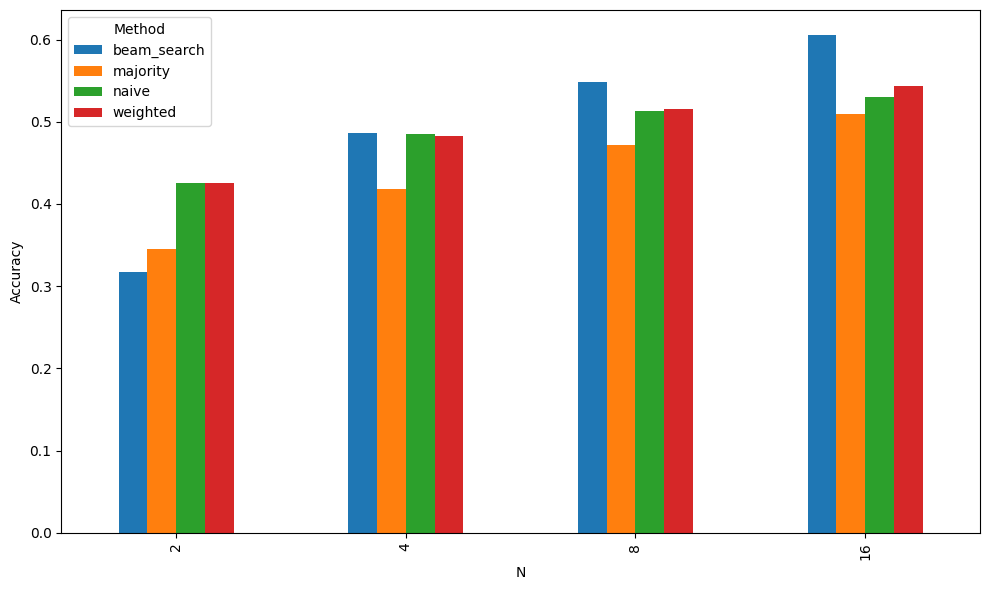

In [55]:
pivot_df = config_summary_df.pivot(index="N", columns="method", values="sl")

# Plot
pivot_df.plot(kind="bar", figsize=(10, 6))

# plt.title("Accuracy by N")
plt.xlabel("N")
plt.ylabel("Accuracy")
plt.legend(title="Method")
plt.tight_layout()
plt.show()

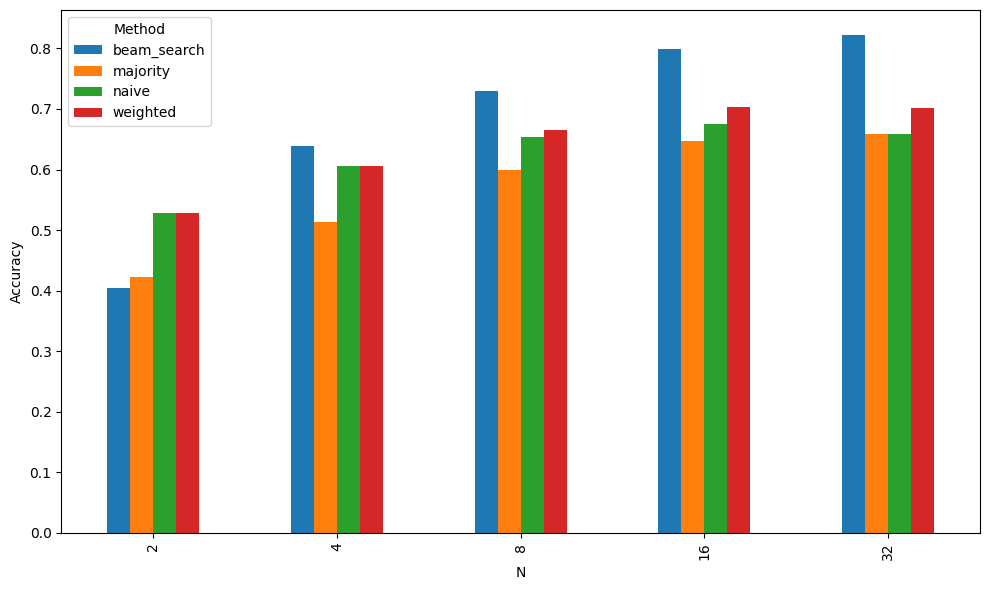

In [ ]:
## Old.

pivot_df = config_summary_df.pivot(index="N", columns="method", values="sl")

# Plot
pivot_df.plot(kind="bar", figsize=(10, 6))

# plt.title("Accuracy by N")
plt.xlabel("N")
plt.ylabel("Accuracy")
plt.legend(title="Method")
plt.tight_layout()
plt.show()

### Optimal-Utility Router

$$\text{Utility}(x, m) = \hat{a}_m(x) - \lambda \cdot \text{Cost}_m(x)$$

$$\text{Query-adaptive}(x, m) = \argmax_m \; \text{Utility}(x, m)

Input: A dataframe that contains rows for different settings (beam size, beam width, chunk size, etc.) and includes: an accuracy column, an avg_cot_token_count column (which is the cost), and a sb_idx column (which is the query).

A parameter, lambda, that controls how much the user is willing to tradeoff accuracy and cost.

For each group (i.e., all rows of the same query, or sb_idx):

It computes a utility value for each row:

$$\text{Utility}(x, m) = \hat{a}_m(x) - \lambda \cdot \text{Cost}_m(x)$$

It finds the row with the highest utility in that group.

Output:
A new DataFrame where each row corresponds to a query and contains:
the best utility found, the accuracy, and cost for that best-performing configuration.

In [184]:
def compute_max_utility_pred(df, lambda_):
    def get_max_utility(group): # verified correctness.
        group = group.copy()
        group["utility"] = group["sl"] - lambda_ * group["token_count"]
        idx_max = group["utility"].idxmax()
        # print("max utility index is: ", idx_max)
        return pd.Series({
            "max_utility": group.loc[idx_max, "utility"],
            "max_predicted_prob": group.loc[idx_max, "predicted_prob"],
            "max_sl": group.loc[idx_max, "sl"], # indicator that keeps track of whether the answer is correct.
            "max_cost": group.loc[idx_max, "token_count"],
            # "max_time": group.loc[idx_max, "time"],
            "N": group.loc[idx_max, "N"],
            "method": group.loc[idx_max, "method"],
        })

    result_df = df.groupby("sb_idx").apply(get_max_utility).reset_index()
    return result_df

In [93]:
# filter for only method_beam_search.
df_test_beam = df_test[df_test["method"] == "beam_search"]

Selected questions: [ 5857  9601   996  6977  9313  1329  8073  6157 12716  4339  9310  5124
 14282  3767 10017 11206  4765  9362  2326  1818  8766 15778 11424 15731
  3148]


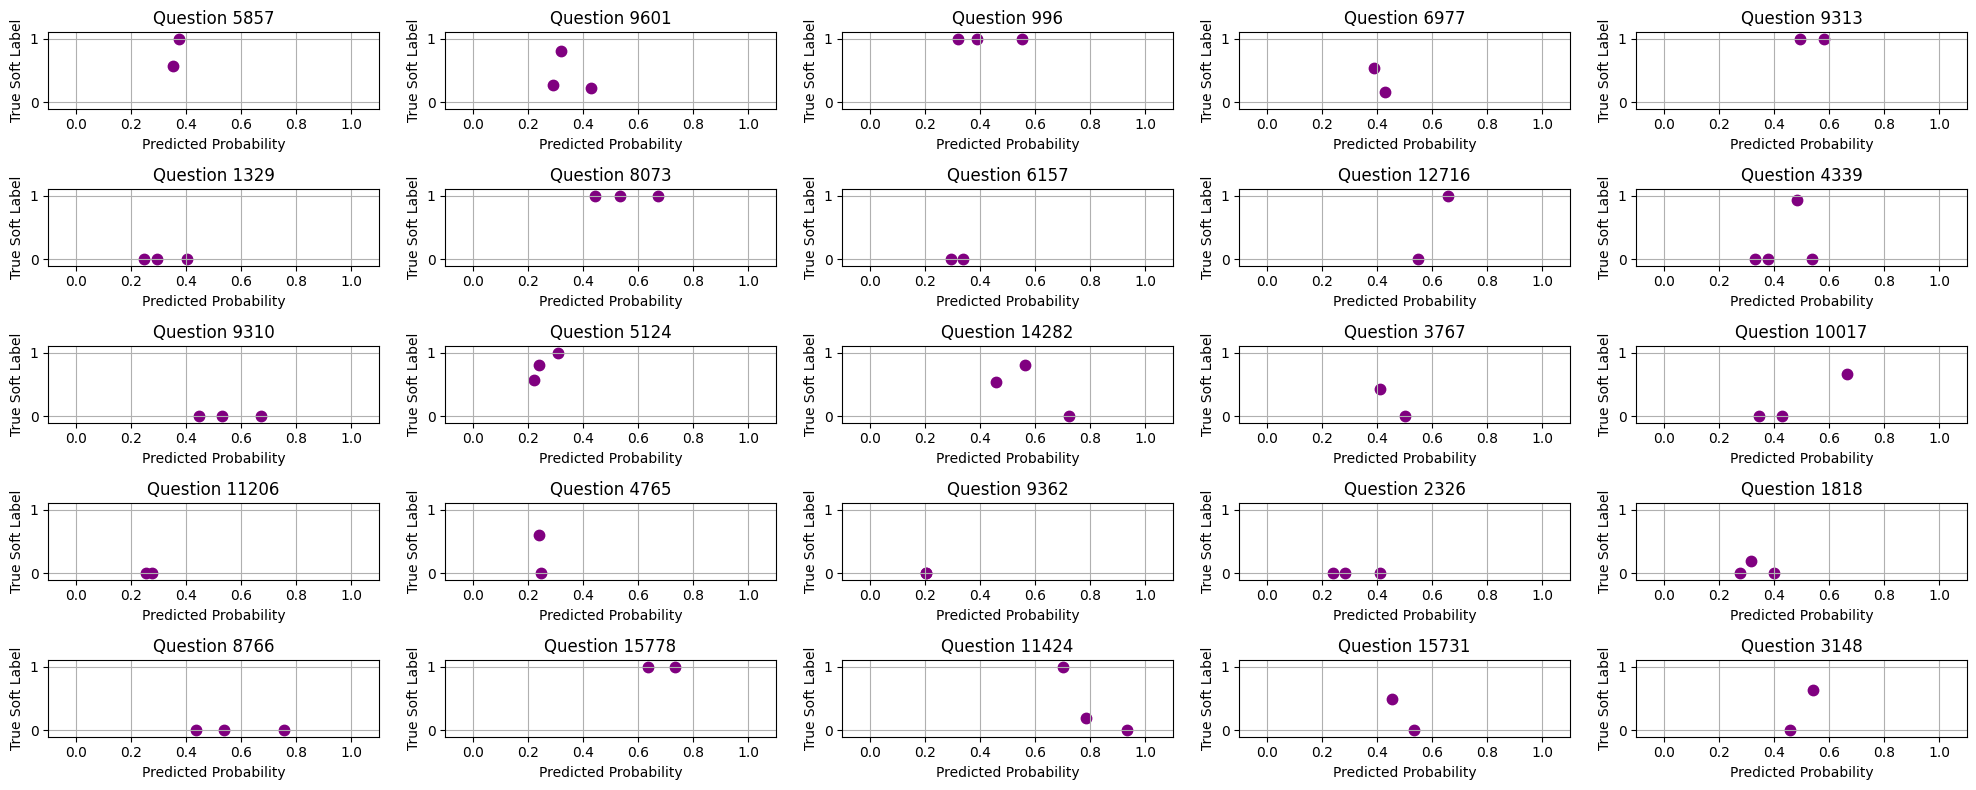

In [94]:
# import matplotlib.pyplot as plt
question = df_test_beam[df_test_beam["sb_idx"] == 10]
# select columns N, indicator, predicted_prob.
question[["N", "sl", "predicted_prob"]]


# Randomly select 10 questions from the test set.
selected_questions = np.random.choice(df_test_beam["sb_idx"].unique(), 25, replace=False)
print(f"Selected questions: {selected_questions}")

# Create a 2x5 grid of subplots
fig, axes = plt.subplots(5, 5, figsize=(20, 8))
axes = axes.flatten()  # Flatten to make indexing easier

# Create plots for each selected question
for i, question_idx in enumerate(selected_questions):
    # Get data for this question
    question = df_test_beam[df_test_beam["sb_idx"] == question_idx]
    
    # Create scatter plot
    axes[i].scatter(question["predicted_prob"], question["sl"], 
                    alpha=1, s=56, color="purple")
    axes[i].set_xlim(-0.1, 1.1)
    axes[i].set_ylim(-0.1, 1.1)
    axes[i].set_title(f"Question {question_idx}")
    axes[i].set_xlabel("Predicted Probability")
    axes[i].set_ylabel("True Soft Label")
    axes[i].grid(True)

plt.tight_layout()
plt.show()


Number of questions in test set: 1954
Mean proportion correct across all questions: 0.4399
Std proportion correct across all questions: 0.3482


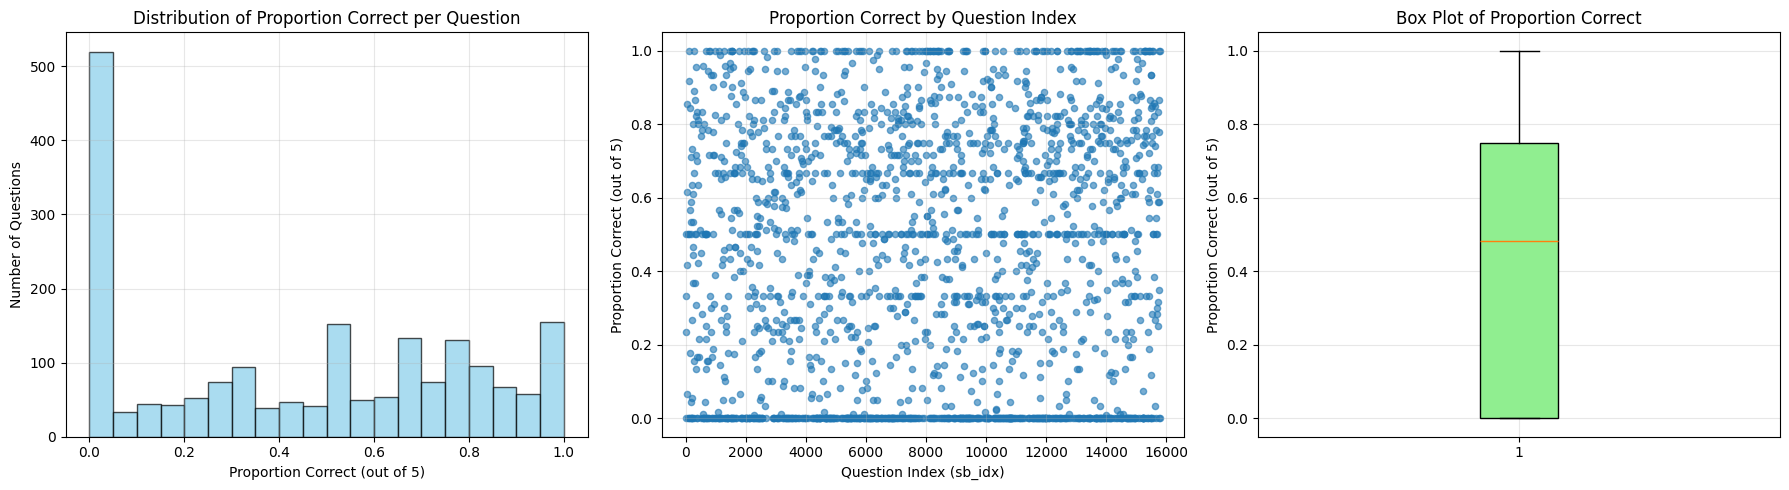


SUMMARY STATISTICS
Minimum proportion correct: 0.0000
25th percentile: 0.0000
Median proportion correct: 0.4833
75th percentile: 0.7500
Maximum proportion correct: 1.0000

BREAKDOWN BY PROPORTION CORRECT RANGES
Proportion 0.0-0.2: 640 questions (32.8%)
Proportion 0.2-0.4: 258 questions (13.2%)
Proportion 0.4-0.6: 277 questions (14.2%)
Proportion 0.6-0.8: 404 questions (20.7%)
Proportion 0.8-1.0: 241 questions (12.3%)

Questions with perfect scores (all 5 correct): 134
Questions with no correct answers: 492


In [95]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Calculate proportion correct for each question in the test set
# Group by sb_idx and calculate the mean of indicator (which gives us the proportion correct)
proportion_correct = df_test_beam.groupby('sb_idx')['sl'].mean()

print(f"Number of questions in test set: {len(proportion_correct)}")
print(f"Mean proportion correct across all questions: {proportion_correct.mean():.4f}")
print(f"Std proportion correct across all questions: {proportion_correct.std():.4f}")

# Create the distribution plot
plt.figure(figsize=(18, 5))

# Create histogram
plt.subplot(1, 3, 1)
plt.hist(proportion_correct, bins=20, edgecolor='black', alpha=0.7, color='skyblue')
plt.xlabel('Proportion Correct (out of 5)')
plt.ylabel('Number of Questions')
plt.title('Distribution of Proportion Correct per Question')
plt.grid(True, alpha=0.3)

# Create scatter plot of proportion correct vs question index
plt.subplot(1, 3, 2)
plt.scatter(proportion_correct.index, proportion_correct.values, alpha=0.6, s=20)
plt.xlabel('Question Index (sb_idx)')
plt.ylabel('Proportion Correct (out of 5)')
plt.title('Proportion Correct by Question Index')
plt.grid(True, alpha=0.3)

# Create box plot
plt.subplot(1, 3, 3)
plt.boxplot(proportion_correct, patch_artist=True, boxprops=dict(facecolor='lightgreen'))
plt.ylabel('Proportion Correct (out of 5)')
plt.title('Box Plot of Proportion Correct')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)
print(f"Minimum proportion correct: {proportion_correct.min():.4f}")
print(f"25th percentile: {proportion_correct.quantile(0.25):.4f}")
print(f"Median proportion correct: {proportion_correct.median():.4f}")
print(f"75th percentile: {proportion_correct.quantile(0.75):.4f}")
print(f"Maximum proportion correct: {proportion_correct.max():.4f}")

# Count questions by proportion correct ranges
print("\n" + "="*60)
print("BREAKDOWN BY PROPORTION CORRECT RANGES")
print("="*60)
ranges = [(0.0, 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, 1.0)]
for low, high in ranges:
    count = ((proportion_correct >= low) & (proportion_correct < high)).sum()
    percentage = (count / len(proportion_correct)) * 100
    print(f"Proportion {low:.1f}-{high:.1f}: {count} questions ({percentage:.1f}%)")

# Questions with perfect scores (all 5 correct)
perfect_questions = proportion_correct[proportion_correct == 1.0]
print(f"\nQuestions with perfect scores (all 5 correct): {len(perfect_questions)}")

# Questions with no correct answers
zero_correct_questions = proportion_correct[proportion_correct == 0.0]
print(f"Questions with no correct answers: {len(zero_correct_questions)}")

#### When Lambda = 0.

In [61]:
adaptive_router_this_lambda = compute_max_utility_pred(df_test, 9e-9)
# view rows 10 through 20.
# daptive_router_0_lambda.iloc[0:60]
# view rows 10 through 20.

/tmp/ipykernel_896897/853710610.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.groupby("sb_idx").apply(get_max_utility).reset_index()


Router is almost always routing between weighted and beam search, transitioning slowly weighted -> beam search as lambda increases.

/tmp/ipykernel_896897/931484531.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.groupby("sb_idx").apply(get_max_utility).reset_index()
/tmp/ipykernel_896897/931484531.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.groupby("sb_idx").apply(get_max_utility).reset_index()
/tmp/ipykernel_896897/931484531.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns.

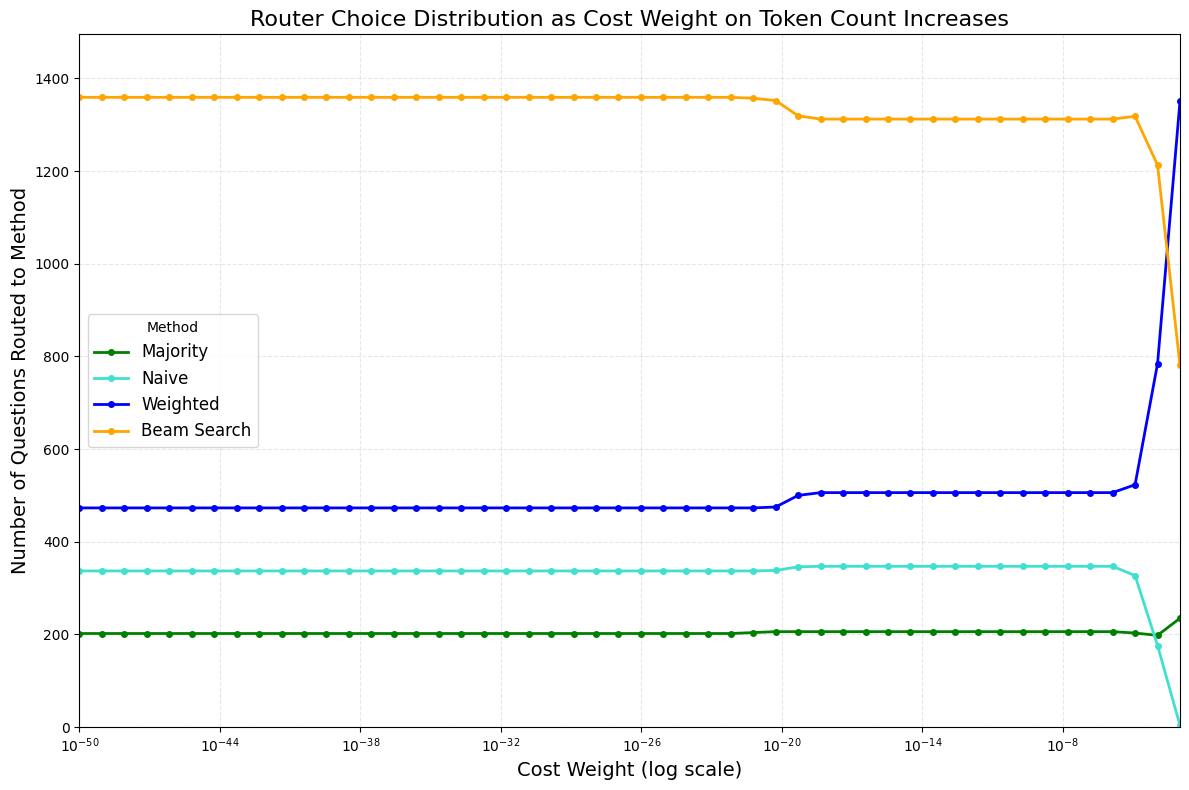

In [98]:
# Plot progression of method distribution as lambda increases from 0 to 1
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Create a range of lambda values from 0 to 1
lambda_values = np.logspace(-50, -3, num=50) 

# Store results for each lambda
method_distributions = []

for lambda_val in lambda_values:
    # Compute optimal method selection for this lambda
    adaptive_router = compute_max_utility_pred(df_test, lambda_val)
    
    # Count the frequency of each method
    method_counts = adaptive_router['method'].value_counts()
    
    # Store the distribution
    method_distributions.append({
        'lambda': lambda_val,
        'majority': method_counts.get('majority', 0),
        'naive': method_counts.get('naive', 0),
        'weighted': method_counts.get('weighted', 0),
        'beam_search': method_counts.get('beam_search', 0)
    })

# Convert to DataFrame
dist_df = pd.DataFrame(method_distributions)

# Create the plot
plt.figure(figsize=(12, 8))

# Plot each method as a line
methods = ['majority', 'naive', 'weighted', 'beam_search']
colors = ['green', 'turquoise', 'blue', 'orange']

for method, color in zip(methods, colors):
    plt.plot(dist_df['lambda'], dist_df[method], 
             label=method.replace('_', ' ').title(), 
             color=color, linewidth=2, marker='o', markersize=4)

plt.xscale('log')  # Set x-axis to log scale

# Optionally adjust axis limits to fit data better
plt.xlim(dist_df['lambda'].min(), dist_df['lambda'].max())
plt.ylim(0, dist_df[methods].values.max() * 1.1)

plt.xlabel('Cost Weight (log scale)', fontsize=14)
plt.ylabel('Number of Questions Routed to Method', fontsize=14)
plt.title('Router Choice Distribution as Cost Weight on Token Count Increases', fontsize=16)
plt.legend(title='Method', fontsize=12)
plt.grid(True, which='both', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

/tmp/ipykernel_896897/931484531.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.groupby("sb_idx").apply(get_max_utility).reset_index()
/tmp/ipykernel_896897/931484531.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.groupby("sb_idx").apply(get_max_utility).reset_index()
/tmp/ipykernel_896897/931484531.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns.

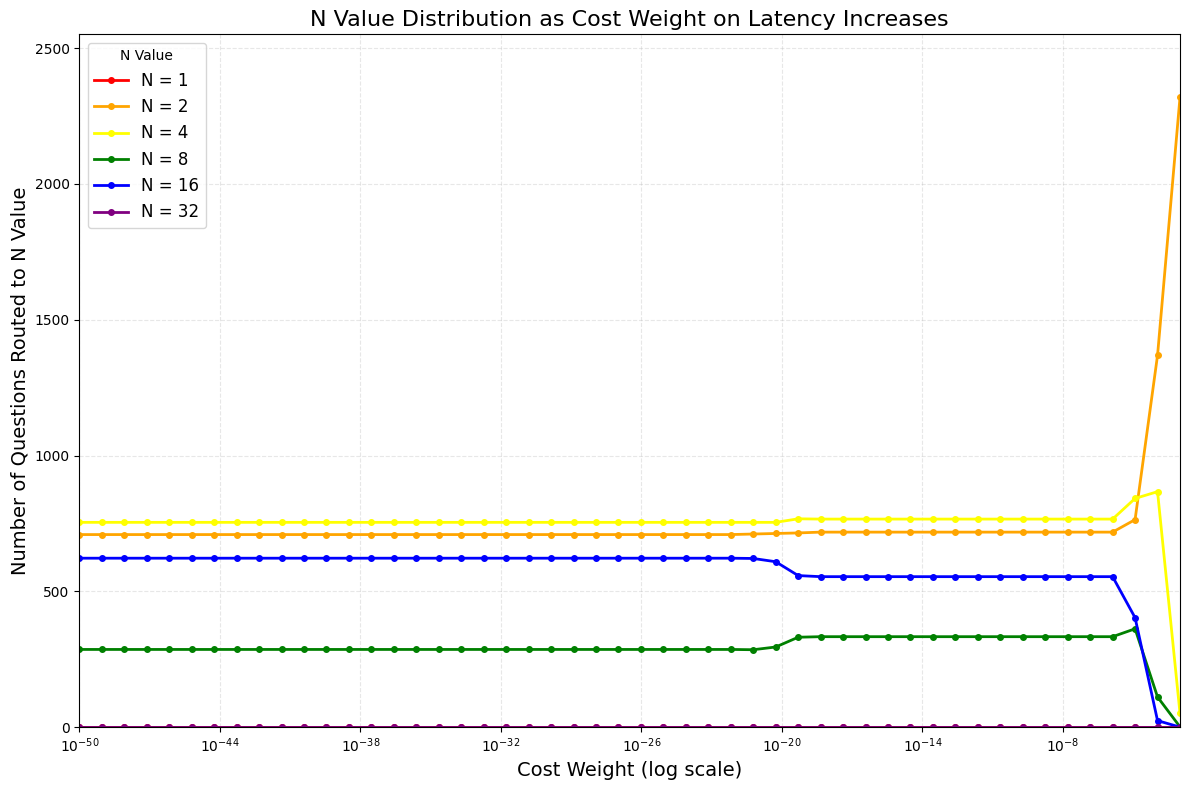

In [92]:
# Create a range of lambda values from 0 to 1 (log scale for better visualization)
lambda_values = np.logspace(-50, -3, num=50) 

# Store results for each lambda
n_distributions = []

for lambda_val in lambda_values:
    # Compute optimal method selection for this lambda
    adaptive_router = compute_max_utility_pred(df_test, lambda_val)
    
    # Count the frequency of each N value
    n_counts = adaptive_router['N'].value_counts()
    
    # Store the distribution
    n_distributions.append({
        'lambda': lambda_val,
        'N_1': n_counts.get(1.0, 0),
        'N_2': n_counts.get(2.0, 0),
        'N_4': n_counts.get(4.0, 0),
        'N_8': n_counts.get(8.0, 0),
        'N_16': n_counts.get(16.0, 0),
        'N_32': n_counts.get(32.0, 0)
    })

# Convert to DataFrame
dist_df = pd.DataFrame(n_distributions)

# Create the plot
plt.figure(figsize=(12, 8))

# Plot each N value as a line
n_values = ['N_1', 'N_2', 'N_4', 'N_8', 'N_16', 'N_32']
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple']

for n_val, color in zip(n_values, colors):
    plt.plot(dist_df['lambda'], dist_df[n_val], 
                label=n_val.replace('_', ' = '), 
                color=color, linewidth=2, marker='o', markersize=4)

plt.xscale('log')  # Set x-axis to log scale

# Optionally adjust axis limits to fit data better
plt.xlim(dist_df['lambda'].min(), dist_df['lambda'].max())
plt.ylim(0, dist_df[n_values].values.max() * 1.1)

plt.xlabel('Cost Weight (log scale)', fontsize=14)
plt.ylabel('Number of Questions Routed to N Value', fontsize=14)
plt.title('N Value Distribution as Cost Weight on Latency Increases', fontsize=16)
plt.legend(title='N Value', fontsize=12)
plt.grid(True, which='both', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

bin
(0.19, 0.2]     126
(0.2, 0.21]     516
(0.21, 0.22]    638
(0.22, 0.23]    533
(0.23, 0.24]    531
               ... 
(0.91, 0.92]     51
(0.92, 0.93]     35
(0.93, 0.94]     23
(0.94, 0.95]     17
(0.95, 0.96]      2
Name: count, Length: 77, dtype: int64


/tmp/ipykernel_896897/2805801493.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calibration = df_test.groupby("bin").agg(


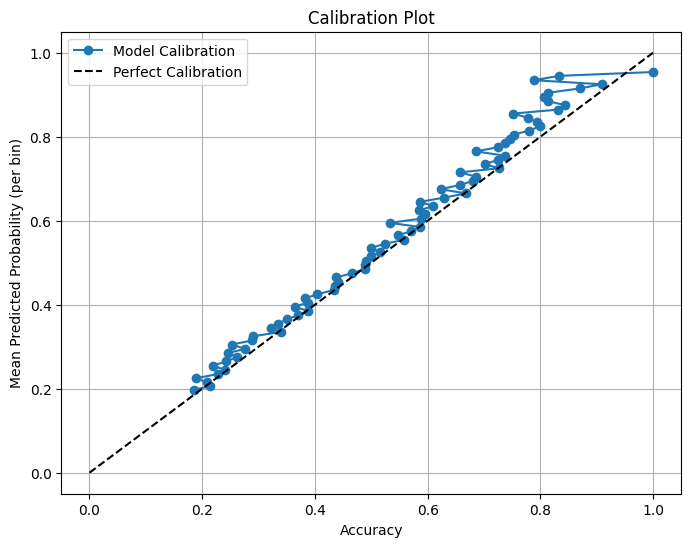

In [87]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Define bin edges and assign each predicted_prob to a bin
num_bins = 100
df_test["bin"] = pd.cut(df_test["predicted_prob"], bins=np.linspace(0, 1, num_bins + 1), include_lowest=True)

# Group by bins and compute average predicted prob and accuracy
calibration = df_test.groupby("bin").agg(
    avg_pred_prob=("predicted_prob", "mean"),
    accuracy=("sl", "mean"),
    count=("sl", "count")
).dropna()

# Print the number of points in each bin
print(calibration["count"])

# Plot calibration curve with flipped axes
plt.figure(figsize=(8, 6))
plt.plot(calibration["accuracy"], calibration["avg_pred_prob"], marker='o', label="Model Calibration")
plt.plot([0, 1], [0, 1], 'k--', label="Perfect Calibration")
plt.xlabel("Accuracy")
plt.ylabel("Mean Predicted Probability (per bin)")
plt.title("Calibration Plot")
plt.grid(True)
plt.legend()
plt.show()


In [185]:
# Sweep over lambda values
lambda_list = np.logspace(-50, -1, num=50) 

In [186]:
results = []

for lambda_value in lambda_list:
    adaptive_router = compute_max_utility_pred(difficult_test_df, lambda_value)
    average_accuracy = adaptive_router["max_sl"].mean() # accuracy as a percentage of questions (out of all questions in the test set) answered correctly.
    average_cost = adaptive_router["max_cost"].mean()
    # average_time = adaptive_router["max_time"].mean()
    average_predicted_prob = adaptive_router["max_predicted_prob"].mean()
    
    results.append({
        "lambda": lambda_value,
        "sl": average_accuracy,
        "token_count": average_cost,
        "predicted_prob": average_predicted_prob,
        # "time": average_time,
    })

# Convert to DataFrame
# query_adaptive_df = pd.DataFrame(results)
oracle_df = pd.DataFrame(results)

/tmp/ipykernel_896897/931484531.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.groupby("sb_idx").apply(get_max_utility).reset_index()
/tmp/ipykernel_896897/931484531.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.groupby("sb_idx").apply(get_max_utility).reset_index()
/tmp/ipykernel_896897/931484531.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns.

In [187]:
# query_adaptive_df["method"] = "adaptive"
# query_adaptive_df.head()
oracle_df['method'] = 'oracle'
oracle_df.head()

,lambda,sl,token_count,predicted_prob,method
0,1.000000e-50,0.085174,2836.401961,0.406697,oracle
1,1.000000e-49,0.085174,2836.401961,0.406697,oracle
2,1.000000e-48,0.085174,2836.401961,0.406697,oracle
3,1.000000e-47,0.085174,2836.401961,0.406697,oracle
4,1.000000e-46,0.085174,2836.401961,0.406697,oracle


In [188]:
# rename column indicator to accuracy.
config_summary_df

,N,method,sl,predicted_prob,token_count
0,2,beam_search,0.000000,0.352762,1260.051556
1,2,majority,0.062718,0.326429,1334.393810
2,2,naive,0.056739,0.383751,1348.797821
3,2,weighted,0.056739,0.377024,1348.797821
4,4,beam_search,0.009158,0.395056,2602.357392
5,4,majority,0.052017,0.367400,2653.055616
6,4,naive,0.049780,0.417051,2750.201847
7,4,weighted,0.050893,0.413061,2742.410714
8,8,beam_search,0.010816,0.504960,5302.313830
9,8,majority,0.039057,0.429978,5406.466891


In [ ]:
### TESTING DF
# Pivot for plotting
pivot_df = config_summary_df_test.pivot(index="N", columns="method", values="sl")

# Plot
pivot_df.plot(kind="bar", figsize=(10, 6))

plt.title("MV, BoN, Weighted BoN - Accuracy by N")
plt.xlabel("N")
plt.ylabel("Accuracy")
plt.legend(title="Method")
plt.tight_layout()
plt.show()

In [181]:
# outer join on the shared columns ("accuracy", "avg_cot_token_count")
query_optimal_static_df = pd.merge(
    query_adaptive_df,
    config_summary_df,
    on=["sl", "token_count", "method", "predicted_prob"],
    how="outer"
)
query_optimal_static_df.head()
# change NaN to -1 for plotting purposes.
query_optimal_static_df = query_optimal_static_df.fillna(-1)

In [182]:
query_optimal_static_df

,lambda,sl,token_count,predicted_prob,method,N
0,-1.0,0.000000,1260.051556,0.352762,beam_search,2.0
1,-1.0,0.008903,10799.571429,0.522046,beam_search,16.0
2,-1.0,0.009158,2602.357392,0.395056,beam_search,4.0
3,-1.0,0.010816,5302.313830,0.504960,beam_search,8.0
4,-1.0,0.028644,11030.649025,0.455903,naive,16.0
...,...,...,...,...,...,...
61,-1.0,0.050893,2742.410714,0.413061,weighted,4.0
62,-1.0,0.052017,2653.055616,0.367400,majority,4.0
63,-1.0,0.056739,1348.797821,0.383751,naive,2.0
64,-1.0,0.056739,1348.797821,0.377024,weighted,2.0


Join the Oracle.

In [189]:
query_optimal_static_df = pd.merge(
    query_optimal_static_df,
    oracle_df,
    on=["lambda", "sl", "token_count", "predicted_prob", "method"],
    how="outer"
)

In [190]:
# Replace NaN values with -1 for plotting purposes
query_optimal_static_df = query_optimal_static_df.fillna(-1)

# Display the merged DataFrame
query_optimal_static_df

,lambda,sl,token_count,predicted_prob,method,N
0,-1.000,0.000000,1260.051556,0.352762,beam_search,2.0
1,-1.000,0.008903,10799.571429,0.522046,beam_search,16.0
2,-1.000,0.009158,2602.357392,0.395056,beam_search,4.0
3,-1.000,0.010816,5302.313830,0.504960,beam_search,8.0
4,-1.000,0.028644,11030.649025,0.455903,naive,16.0
...,...,...,...,...,...,...
111,0.001,0.058529,1601.847712,0.381182,oracle,-1.0
112,0.010,0.046264,1601.847712,0.398222,adaptive,-1.0
113,0.010,0.058529,1601.847712,0.381182,oracle,-1.0
114,0.100,0.046264,1601.847712,0.398222,adaptive,-1.0


In [191]:
# arrange in descending order of sl.
query_optimal_static_df.sort_values(by="sl", ascending=True)

,lambda,sl,token_count,predicted_prob,method,N
0,-1.000000e+00,0.000000,1260.051556,0.352762,beam_search,2.0
1,-1.000000e+00,0.008903,10799.571429,0.522046,beam_search,16.0
2,-1.000000e+00,0.009158,2602.357392,0.395056,beam_search,4.0
3,-1.000000e+00,0.010816,5302.313830,0.504960,beam_search,8.0
4,-1.000000e+00,0.028644,11030.649025,0.455903,naive,16.0
...,...,...,...,...,...,...
87,1.000000e-15,0.085174,2783.349673,0.405808,oracle,-1.0
43,1.000000e-37,0.085174,2836.401961,0.406697,oracle,-1.0
89,1.000000e-14,0.085174,2783.349673,0.405808,oracle,-1.0
67,1.000000e-25,0.085174,2836.401961,0.406697,oracle,-1.0


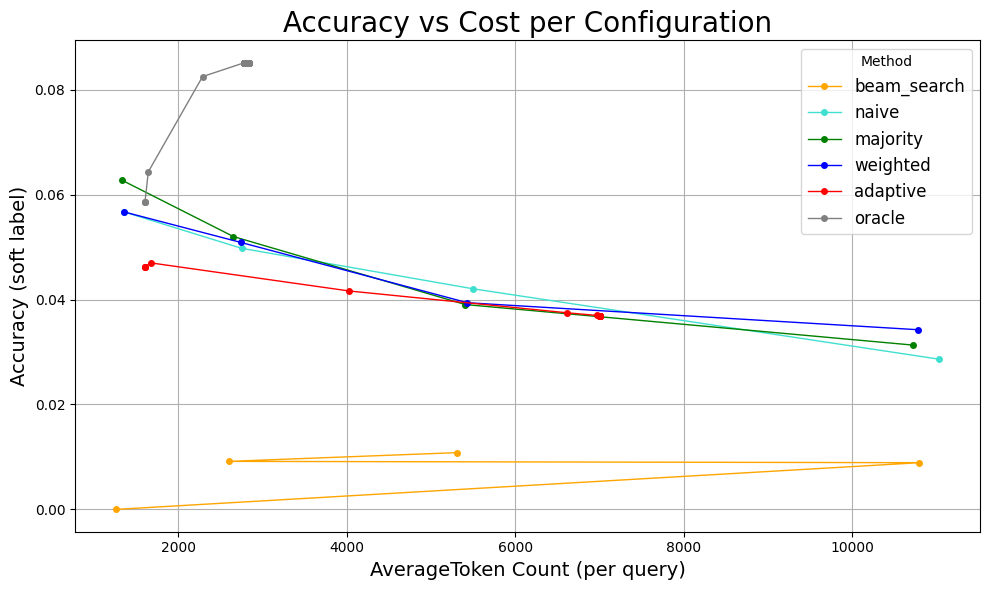

In [192]:
# Assign unique colors for each method
method_colors = {
    "majority": "green",
    "naive": "turquoise",
    "weighted": "blue",
    "beam_search": "orange",
    "adaptive": "red",  # Query-adaptive router
    "oracle": "gray"  # Oracle router
}

# Create a figure
plt.figure(figsize=(10, 6))

# Iterate over each method and plot its points and connecting lines
for method in query_optimal_static_df["method"].unique():
    method_df = query_optimal_static_df[query_optimal_static_df["method"] == method]
    color = method_colors.get(method, "adaptive")  # Default to gray if method is unknown
    plt.plot(
        method_df["token_count"], 
        method_df["sl"], 
        marker="o", 
        linestyle="-", 
        color=color, 
        label=method,
        markersize=4,
        linewidth=1
    )

# Add labels and title
plt.xlabel("AverageToken Count (per query)", fontsize=14)
plt.ylabel("Accuracy (soft label)", fontsize=14)
plt.title("Accuracy vs Cost per Configuration", fontsize=20)
plt.legend(title="Method", fontsize=12)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

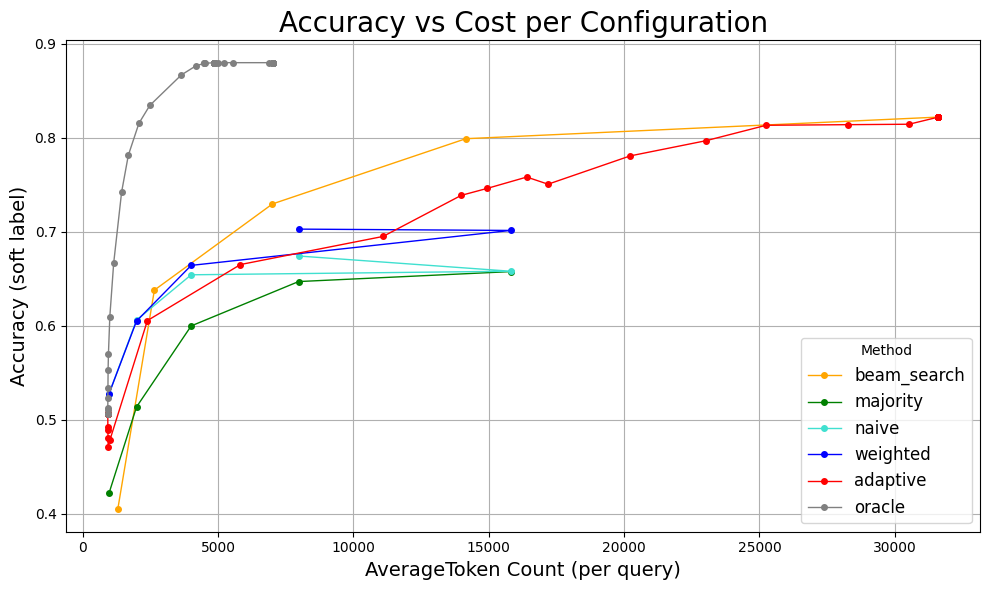

In [ ]:
# Assign unique colors for each method
method_colors = {
    "majority": "green",
    "naive": "turquoise",
    "weighted": "blue",
    "beam_search": "orange",
    "adaptive": "red",  # Query-adaptive router
    "oracle": "gray"  # Oracle router
}

# Create a figure
plt.figure(figsize=(10, 6))

# Iterate over each method and plot its points and connecting lines
for method in query_optimal_static_df["method"].unique():
    method_df = query_optimal_static_df[query_optimal_static_df["method"] == method]
    color = method_colors.get(method, "adaptive")  # Default to gray if method is unknown
    plt.plot(
        method_df["token_count"], 
        method_df["sl"], 
        marker="o", 
        linestyle="-", 
        color=color, 
        label=method,
        markersize=4,
        linewidth=1
    )

# Add labels and title
plt.xlabel("AverageToken Count (per query)", fontsize=14)
plt.ylabel("Accuracy (soft label)", fontsize=14)
plt.title("Accuracy vs Cost per Configuration", fontsize=20)
plt.legend(title="Method", fontsize=12)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

['majorityx1.0', 'naivex1.0', 'weightedx1.0', 'majorityx1.0', 'naivex1.0', 'weightedx1.0', 'majorityx1.0', 'naivex1.0', 'weightedx1.0', 'majorityx2.0', 'qa', 'majorityx4.0', 'naivex2.0', 'weightedx2.0', 'qa', 'naivex4.0', 'weightedx4.0', 'majorityx8.0', 'naivex8.0', 'weightedx8.0', 'majorityx16.0', 'qa', 'naivex16.0', 'naivex32.0', 'majorityx32.0', 'weightedx16.0', 'weightedx32.0', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa']


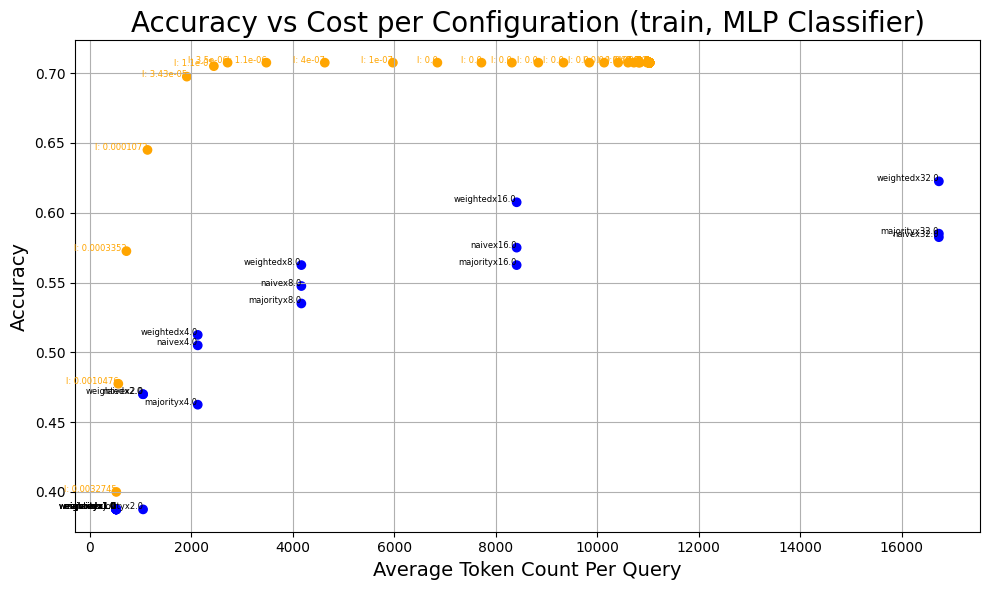

In [ ]:
# Create color labels and text labels (sklearn MLPClassifier)
colors = ['orange' if (row['method']) == -1 else 'blue'
          for _, row in query_optimal_static_df.iterrows()]

text_labels = ["qa" if (row['method']) == -1
               else f"{row['method']}x{row['N']}"
               for _, row in query_optimal_static_df.iterrows()]

print(text_labels)
plt.figure(figsize=(10, 6))
plt.scatter(query_optimal_static_df["token_count"], query_optimal_static_df["indicator"], color=colors)

# Annotate each point
for i, label in enumerate(text_labels):
    if label != "qa":
        plt.annotate(label,
                    (query_optimal_static_df["token_count"][i], query_optimal_static_df["indicator"][i]),
                    textcoords="offset points", xytext=(0, 0), ha='right', fontsize=6, color='black')
    elif label == "qa":
        plt.annotate(f"l: {round(query_optimal_static_df["lambda"][i], 7)}",
                    (query_optimal_static_df["token_count"][i], query_optimal_static_df["indicator"][i]),
                    textcoords="offset points", xytext=(0, 0), ha='right', fontsize=6, color='orange')

plt.xlabel("Average Token Count Per Query", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Accuracy vs Cost per Configuration (train, MLP Classifier)", fontsize=20)
plt.grid(True)
plt.tight_layout()

['majorityx1.0', 'naivex1.0', 'weightedx1.0', 'majorityx1.0', 'naivex1.0', 'weightedx1.0', 'majorityx1.0', 'naivex1.0', 'weightedx1.0', 'qa', 'qa', 'majorityx2.0', 'qa', 'majorityx4.0', 'naivex2.0', 'weightedx2.0', 'qa', 'naivex4.0', 'weightedx4.0', 'majorityx8.0', 'naivex8.0', 'qa', 'weightedx8.0', 'majorityx16.0', 'naivex16.0', 'naivex32.0', 'majorityx32.0', 'weightedx16.0', 'weightedx32.0', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa']


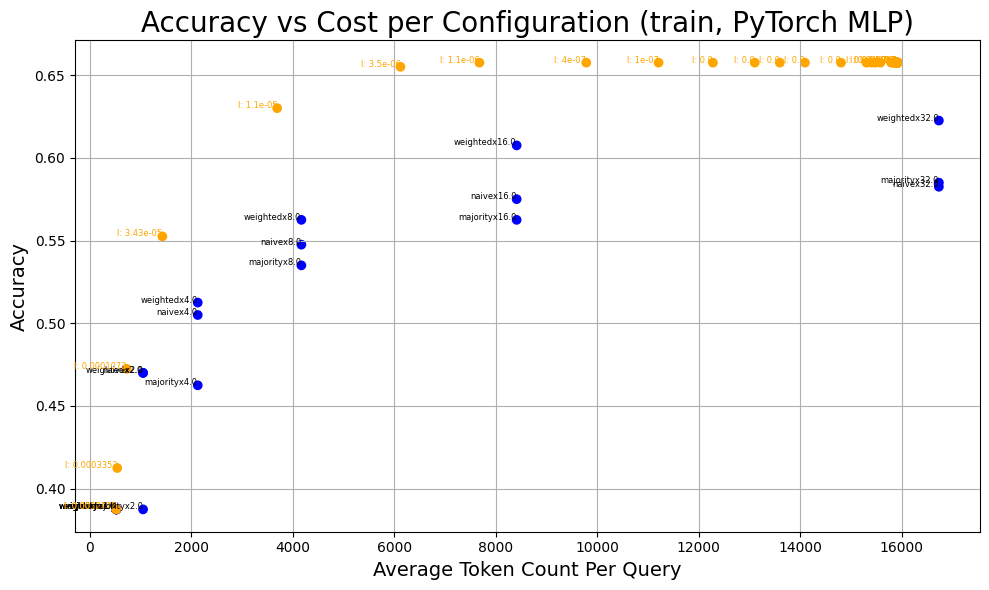

In [ ]:
# Create color labels and text labels (pyTorch MLP)
colors = ['orange' if (row['method']) == -1 else 'blue'
          for _, row in query_optimal_static_df.iterrows()]

text_labels = ["qa" if (row['method']) == -1
               else f"{row['method']}x{row['N']}"
               for _, row in query_optimal_static_df.iterrows()]

print(text_labels)
plt.figure(figsize=(10, 6))
plt.scatter(query_optimal_static_df["token_count"], query_optimal_static_df["indicator"], color=colors)

# Annotate each point
for i, label in enumerate(text_labels):
    if label != "qa":
        plt.annotate(label,
                    (query_optimal_static_df["token_count"][i], query_optimal_static_df["indicator"][i]),
                    textcoords="offset points", xytext=(0, 0), ha='right', fontsize=6, color='black')
    elif label == "qa":
        plt.annotate(f"l: {round(query_optimal_static_df["lambda"][i], 7)}",
                    (query_optimal_static_df["token_count"][i], query_optimal_static_df["indicator"][i]),
                    textcoords="offset points", xytext=(0, 0), ha='right', fontsize=6, color='orange')

plt.xlabel("Average Token Count Per Query", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Accuracy vs Cost per Configuration (train, PyTorch MLP)", fontsize=20)
plt.grid(True)
plt.tight_layout()

['majorityx1.0', 'naivex1.0', 'weightedx1.0', 'majorityx1.0', 'naivex1.0', 'weightedx1.0', 'majorityx1.0', 'naivex1.0', 'weightedx1.0', 'majorityx2.0', 'qa', 'majorityx4.0', 'naivex2.0', 'weightedx2.0', 'qa', 'naivex4.0', 'weightedx4.0', 'majorityx8.0', 'naivex8.0', 'weightedx8.0', 'majorityx16.0', 'qa', 'naivex16.0', 'naivex32.0', 'majorityx32.0', 'weightedx16.0', 'weightedx32.0', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa']


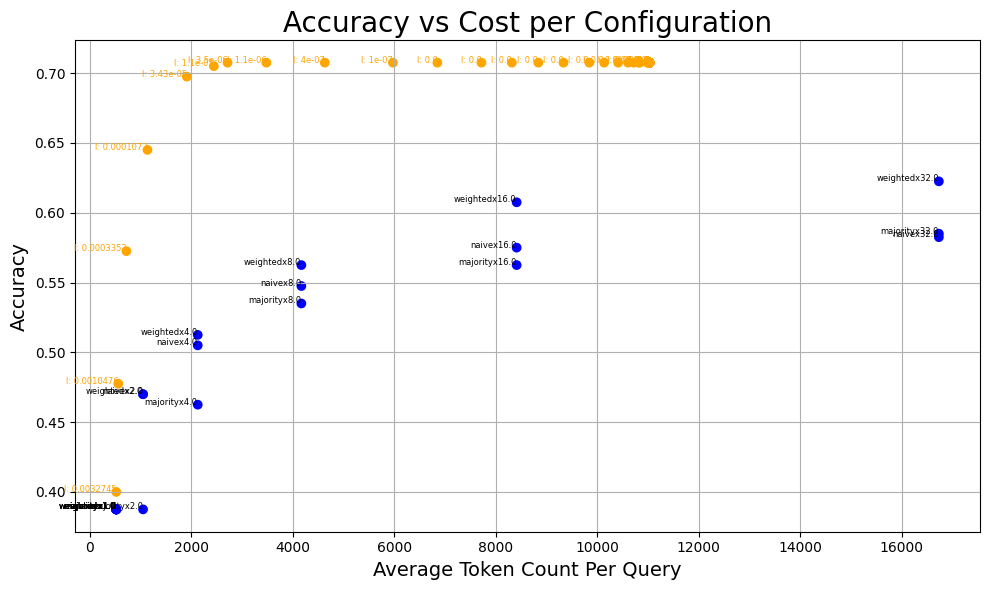

In [ ]:
# Create color labels and text labels
colors = ['orange' if (row['method']) == -1 else 'blue'
          for _, row in query_optimal_static_df.iterrows()]

text_labels = ["qa" if (row['method']) == -1
               else f"{row['method']}x{row['N']}"
               for _, row in query_optimal_static_df.iterrows()]

print(text_labels)
plt.figure(figsize=(10, 6))
plt.scatter(query_optimal_static_df["token_count"], query_optimal_static_df["indicator"], color=colors)

# Annotate each point
for i, label in enumerate(text_labels):
    if label != "qa":
        plt.annotate(label,
                    (query_optimal_static_df["token_count"][i], query_optimal_static_df["indicator"][i]),
                    textcoords="offset points", xytext=(0, 0), ha='right', fontsize=6, color='black')
    elif label == "qa":
        plt.annotate(f"l: {round(query_optimal_static_df["lambda"][i], 7)}",
                    (query_optimal_static_df["token_count"][i], query_optimal_static_df["indicator"][i]),
                    textcoords="offset points", xytext=(0, 0), ha='right', fontsize=6, color='orange')

plt.xlabel("Average Token Count Per Query", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Accuracy vs Cost per Configuration", fontsize=20)
plt.grid(True)
plt.tight_layout()

# plt.savefig("figs/accuracy_vs_cost_by_config3", dpi=300, bbox_inches='tight')

# notes: make sure we are plotting the accuracy. the probe should pick the weighted response.
# should not go below the blue dots. (check what you are actually plotting).